# A3: NeuralNetwork Class

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1">Requirements</a></span></li><li><span><a href="#Code-for-NeuralNetwork-Class-Saved-in-File-neuralnetworkA3.py" data-toc-modified-id="Code-for-NeuralNetwork-Class-Saved-in-File-neuralnetworkA3.py-2">Code for <code>NeuralNetwork</code> Class Saved in File <code>neuralnetworkA3.py</code></a></span></li><li><span><a href="#Example-Results" data-toc-modified-id="Example-Results-3">Example Results</a></span></li><li><span><a href="#Application-to-Seoul-Bike-Sharing-Demand-Data" data-toc-modified-id="Application-to-Seoul-Bike-Sharing-Demand-Data-4">Application to Seoul Bike Sharing Demand Data</a></span></li></ul></div>

## Requirements

In this assignment, you will complete the implementation of the `NeuralNetwork` class, starting with the code included in the next code cell.  Your implementation must meet the requirements described in the doc-strings.

Run the code in [05 Optimizers](https://www.cs.colostate.edu/~anderson/cs545/notebooks/05%20Optimizers.ipynb) to create the file `optimizers.py` for use in this assignment.

Then apply your `NeuralNetwork` class to the problem of predicting the value of houses in Boston as described below.

## Code for `NeuralNetwork` Class Saved in File `neuralnetworkA3.py`

In [1]:
import numpy as np

In [2]:
%%writefile neuralnetworkA3.py

import numpy as np
import optimizers as opt


class NeuralNetwork():
    """
    A class that represents a neural network for nonlinear regression.

    Attributes
    ----------
    n_inputs : int
        The number of values in each sample
    n_hidden_units_by_layers : list of ints, or empty
        The number of units in each hidden layer.
        Its length specifies the number of hidden layers.
    n_outputs : int
        The number of units in output layer
    all_weights : one-dimensional numpy array
        Contains all weights of the network as a vector
    Ws : list of two-dimensional numpy arrays
        Contains matrices of weights in each layer,
        as views into all_weights
    all_gradients : one-dimensional numpy array
        Contains all gradients of mean square error with
        respect to each weight in the network as a vector
    Grads : list of two-dimensional numpy arrays
        Contains matrices of gradients weights in each layer,
        as views into all_gradients
    performance_trace : list of floats
        Mean square error (unstandardized) after each epoch
    n_epochs : int
        Number of epochs trained so far
    X_means : one-dimensional numpy array
        Means of the components, or features, across samples
    X_stds : one-dimensional numpy array
        Standard deviations of the components, or features, across samples
    T_means : one-dimensional numpy array
        Means of the components of the targets, across samples
    T_stds : one-dimensional numpy array
        Standard deviations of the components of the targets, across samples
        
        
    Methods
    -------
    make_weights_and_views(shapes)
        Creates all initial weights and views for each layer

    train(X, T, n_epochs, method='sgd', learning_rate=None, verbose=True)
        Trains the network using input and target samples by rows in X and T

    use(X)
        Applies network to inputs X and returns network's output
    """

    def __init__(self, n_inputs, n_hidden_units_by_layers, n_outputs):
        """Creates a neural network with the given structure

        Parameters
        ----------
        n_inputs : int
            The number of values in each sample
        n_hidden_units_by_layers : list of ints, or empty
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """

        # Assign attribute values. 
        # Set performance_trace to [].
        # Set self.X_means to None to indicate
        # that standardization parameters have not been calculated.
        self.n_inputs = n_inputs
        self.n_hidden_units_by_layers = n_hidden_units_by_layers
        self.n_outputs = n_outputs

        self.performance_trace = []
        
        self.n_epochs = 0
        self.rho = None
        
        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None
  

        # Build list of shapes for weight matrices in each layer
        if n_hidden_units_by_layers:
            # 1st layer weight shape
            shapes = [(n_inputs+1, n_hidden_units_by_layers[0])]  
            # 2nd to n-1 layer weight shape
            for i in range(len(n_hidden_units_by_layers)-1):
                shapes.append((n_hidden_units_by_layers[i]+1, n_hidden_units_by_layers[i+1])) 
            # last (n) layer weight
            shapes.append((n_hidden_units_by_layers[-1]+1, n_outputs))  
            
        else: 
            shapes = [(n_inputs+1, n_outputs)]  # shape of weight if no hidden layer
        
            
        # Call make_weights_and_views to create all_weights and Ws
        
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Call make_weights_and_views to create all_gradients and Grads
        
        self.all_gradients, self.Grads = self.make_weights_and_views(shapes)


    def make_weights_and_views(self, shapes):
        """Creates vector of all weights and views for each layer

        Parameters
        ----------
        shapes : list of pairs of ints
            Each pair is number of rows and columns of weights in each layer.
            Number of rows is number of inputs to layer (including constant 1).
            Number of columns is number of units, or outputs, in layer.

        Returns
        -------
        Vector of all weights, and list of views into this vector for each layer
        """
        # Create one-dimensional numpy array of all weights with random initial values
        num_in_weights = sum([np.prod(s) for s in shapes])
        all_weights = np.random.uniform(-1, 1, size=(num_in_weights, 1)).flatten()

        # Build weight matrices as list of views (pairs of number of rows and number 
        # of columns) by reshaping corresponding elements from vector of all weights 
        # into correct shape for each layer. 
        first_idx = 0
        Ws = []
        for shp in shapes:
            nw = shp[0] * shp[1]
            last_idx = first_idx + nw
            Ws.append(all_weights[first_idx:last_idx].reshape(shp))
            first_idx = last_idx
        
        # Divide values of each weight matrix by square root of number of its inputs.
        for w in Ws:
            w[:] /= np.sqrt(w.shape[0] + 1)
        
        # Set output layer weights to zero.
        Ws[-1][:] = np.zeros(shapes[-1])
        
        return all_weights, Ws
    
    
    def __repr__(self):
        return 'NeuralNetwork({}, {}, {})'.format(self.n_inputs, self.n_hidden_units_by_layers, self.n_outputs)

    def __str__(self):
        s = self.__repr__()
        if self.n_epochs > 0:  # self.total_epochs
            s += '\n Trained for {} epochs.'.format(self.n_epochs)
            s += '\n Final standardized training error {:.4g}.'.format(self.performance_trace[-1])
        return s
 
    def train(self, X, T, n_epochs, method='sgd', learning_rate=None, verbose=True):
        """Updates the weights.

        Parameters
        ----------
        X : two-dimensional numpy array 
            number of samples  by  number of input components
        T : two-dimensional numpy array
            number of samples  by  number of output components
        n_epochs : int
            Number of passes to take through all samples
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        verbose: boolean
            If True, progress is shown with print statements
        """
        self.learning_rate = learning_rate
        
        # Calculate and assign standardization parameters
        self.X_means = X.mean(axis = 0)
        self.X_stds = X.std(axis = 0)
        self.T_means = T.mean(axis = 0)
        self.T_stds = T.std(axis = 0)

        # Standardize X and T.  Assign back to X and T.
        X = (X - self.X_means) / self.X_stds
        T = (T - self.T_means) / self.T_stds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = opt.Optimizers(self.all_weights)

        # Define function to convert mean-square error to root-mean-square error,
        # Here we use a lambda function just to illustrate its use.  
        # We could have also defined this function with
        # def error_convert_f(err):
        #     return np.sqrt(err)

        error_convert_f = lambda err: np.sqrt(err) 
        
        # Call the requested optimizer method to train the weights.
        if method == 'sgd':
            
            performance_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                              fargs=[X, T], n_epochs=n_epochs,
                                              learning_rate=learning_rate,
                                              error_convert_f=error_convert_f, 
                                              error_convert_name='RMSE',
                                              verbose=verbose)

        elif method == 'adam':

            performance_trace = optimizer.adam(self.error_f, self.gradient_f,
                                               fargs=[X, T], n_epochs=n_epochs,
                                               learning_rate=learning_rate,
                                               error_convert_f=error_convert_f, 
                                               error_convert_name='RMSE',
                                               verbose=verbose)

        elif method == 'scg':

            performance_trace = optimizer.scg(self.error_f, self.gradient_f,
                                              fargs=[X, T], n_epochs=n_epochs,
                                              error_convert_f=error_convert_f, 
                                              error_convert_name='RMSE',
                                              verbose=verbose)

        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")

        self.n_epochs += len(performance_trace)
        self.performance_trace += performance_trace

        # Return neural network object to allow applying other methods
        # after training, such as:    Y = nnet.train(X, T, 100, 0.01).use(X)

        return self

    def _add_ones(self, X):
        return np.insert(X, 0, 1, 1)
    
    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X.
        
        Parameters
        ----------
        X : input samples, standardized.

        Returns
        -------
        Standardized outputs of all layers as list, include X as first element.
        """        
        self.Zs = [X]
        # Append output of each layer to list in self.Zs, then return it.
        weights = self.Ws
        Z = X
        # for layers upto n-1
        for i in range(len(weights) - 1):
            Z_w = np.tanh(self._add_ones(Z) @ weights[i])               
            Z = Z_w
            self.Zs.append(Z_w)
            
        # for output layer
        if self.n_hidden_units_by_layers:
            self.Zs.append(self._add_ones(Z_w) @ weights[-1]) 
        else:
            self.Zs.append(self._add_ones(X) @ weights[-1])
            
        return self.Zs
        

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        """Calculate output of net given input X and its mean squared error.
        Function to be minimized by optimizer.

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  by  number of input components
        T : two-dimensional numpy array, standardized
            number of samples  by  number of output components

        Returns
        -------
        Standardized mean square error as scalar float that is the mean
        square error over all samples and all network outputs.
        """
        # Call _forward, calculate mean square error and return it.
        Y = self._forward(X)[-1]
        mse = np.mean(((T - Y)) **2)
        return mse
         

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward already called
        so input and all layer outputs stored in self.Zs

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  x  number of input components
        T : two-dimensional numpy array, standardized
            number of samples  x  number of output components

        Returns
        -------
        Vector of gradients of mean square error wrt all weights
        """
        # Assumes forward_pass just called with layer outputs saved in self.Zs.
        
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        n_layers = len(self.n_hidden_units_by_layers) + 1

        # delta is delta matrix to be back propagated.
        # Dividing by n_samples and n_outputs here replaces the scaling of the learning rate.
        
        delta = (T - self.Zs[-1]) / (n_samples * n_outputs)

        # Step backwards through the layers to back-propagate the error (delta)
        
        for layeri in range(n_layers - 1, -1, -1):
            
            # gradient of all but bias weights
            Z = self.Zs[layeri]
            W = self.Ws[layeri]
            self.Grads[layeri][:] = -(self._add_ones(Z).T @ delta)
            
            # Back-propagate this layer's delta to previous layer
            if layeri > 0:
                delta = delta @ W[1:, :].T * (1 - Z ** 2)
            
        return self.all_gradients

    def use(self, X):
        """Return the output of the network for input samples as rows in X.
        X assumed to not be standardized.

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  by  number of input components, unstandardized

        Returns
        -------
        Output of neural network, unstandardized, as numpy array
        of shape  number of samples  by  number of outputs
        """

        # Standardize X
        Xs = (X - self.X_means) / self.X_stds
        
        Ys = self._forward(Xs)[-1]
        # Unstandardize output Y before returning it
        Y = Ys * self.T_stds + self.T_means
        
        return Y

    def get_performance_trace(self):
        """Returns list of unstandardized root-mean square error for each epoch"""
        return self.performance_trace

Overwriting neuralnetworkA3.py


## Example Results

Here we test the `NeuralNetwork` class with some simple data.  


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetworkA3 as nn  # Your file produced from the above code cell.

In [4]:
X = np.arange(0, 2, 0.5).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

nnet = nn.NeuralNetwork(X.shape[1], [2, 2], 1)
    
# Set all weights here to allow comparison of your calculations
# Must use [:] to overwrite values in all_weights.
# Without [:], new array is assigned to self.all_weights, so self.Ws no longer refer to same memory
nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001

nnet.train(X, T, n_epochs=1, method='sgd', learning_rate=0.1)

nnet.Ws

sgd: Epoch 1 RMSE=1.00005


[array([[-1.51603124e-07,  9.99801782e-04],
        [ 2.00719909e-03,  3.00940664e-03]]),
 array([[0.00398889, 0.00498788],
        [0.00600106, 0.00700115],
        [0.00800157, 0.00900172]]),
 array([[0.00898958],
        [0.01099768],
        [0.01199691]])]

In [5]:
nnet.Zs

[array([[-1.34164079],
        [-0.4472136 ],
        [ 0.4472136 ],
        [ 1.34164079]]),
 array([[-0.00268328, -0.00302491],
        [-0.00089443, -0.00034164],
        [ 0.00089443,  0.00234164],
        [ 0.00268328,  0.00502488]]),
 array([[0.00395968, 0.00495395],
        [0.00399188, 0.00499062],
        [0.00402408, 0.00502729],
        [0.00405628, 0.00506396]]),
 array([[0.010103  ],
        [0.0101038 ],
        [0.01010459],
        [0.01010539]])]

In [6]:
nnet.Grads

[array([[ 1.51603124e-06,  1.98217653e-06],
        [-7.19909102e-05, -9.40663907e-05]]),
 array([[ 1.11145896e-04,  1.21249680e-04],
        [-1.05587719e-05, -1.15185542e-05],
        [-1.57268813e-05, -1.71564392e-05]]),
 array([[1.01041953e-02],
        [2.32194989e-05],
        [3.09340617e-05]])]

In [7]:
Y = nnet.use(X)
Y

array([[-0.06308723],
       [-0.06308687],
       [-0.06308651],
       [-0.06308615]])


method is sgd and rho is 0.05

sgd: Epoch 1000 RMSE=1.00000
sgd: Epoch 2000 RMSE=1.00000
sgd: Epoch 3000 RMSE=0.99539
sgd: Epoch 4000 RMSE=0.97261
sgd: Epoch 5000 RMSE=0.68183
sgd: Epoch 6000 RMSE=0.55867
sgd: Epoch 7000 RMSE=0.54350
sgd: Epoch 8000 RMSE=0.43648
sgd: Epoch 9000 RMSE=0.40719
sgd: Epoch 10000 RMSE=0.39497

method is adam and rho is 0.02

Adam: Epoch 1000 RMSE=0.83076
Adam: Epoch 2000 RMSE=0.64750
Adam: Epoch 3000 RMSE=0.64601
Adam: Epoch 4000 RMSE=0.64567
Adam: Epoch 5000 RMSE=0.64550
Adam: Epoch 6000 RMSE=0.64540
Adam: Epoch 7000 RMSE=0.64532
Adam: Epoch 8000 RMSE=0.64527
Adam: Epoch 9000 RMSE=0.65070
Adam: Epoch 10000 RMSE=0.64520

method is scg and rho is None

SCG: Iteration 1000 RMSE=0.64487
SCG: Iteration 2000 RMSE=0.46553
SCG: Iteration 3000 RMSE=0.45547
SCG: Iteration 4000 RMSE=0.32589
SCG: Iteration 5000 RMSE=0.30054
SCG: Iteration 6000 RMSE=0.28646
SCG: Iteration 7000 RMSE=0.28084
SCG: Iteration 8000 RMSE=0.27979
SCG: Iteration 9000 RMSE=0.27917
SCG: Iteration

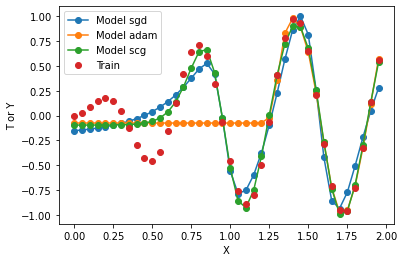

In [8]:
X = np.arange(0, 2, 0.05).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

n_epochs = 10000
method_rhos = [('sgd', 0.05),
               ('adam', 0.02),
               ('scg', None)]
errors = []
for method, rho in method_rhos:
    
    print('\n=========================================')
    print(f'method is {method} and rho is {rho}')
    print('=========================================\n')

    nnet = nn.NeuralNetwork(X.shape[1], [2, 2], 1)
    
    # Set all weights here to allow comparison of your calculations
    # Must use [:] to overwrite values in all_weights.
    # Without [:], new array is assigned to self.all_weights, so self.Ws no longer refer to same memory
    nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001
    
    nnet.train(X, T, n_epochs, method=method, learning_rate=rho)
    Y = nnet.use(X)
    errors.append(nnet.get_performance_trace())
    plt.plot(X, Y, 'o-', label='Model ' + method)

plt.plot(X, T, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend();

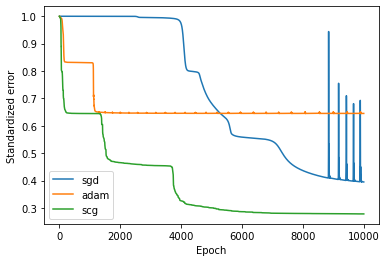

In [9]:
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

## Application to Seoul Bike Sharing Demand Data

Download data from [bike-sharing.csv](https://www.cs.colostate.edu/~anderson/cs545/notebooks/bike-sharing.csv).  This is data modified very slightly from [UC Irvine ML Repo](https://archive-beta.ics.uci.edu/ml/datasets/seoul+bike+sharing+demand#Abstract). Read it into python using the `pandas.read_csv` function.  Assign `X` and `T` as shown.

In [10]:
import pandas as pd

data = pd.read_csv('SeoulBikeData.csv')
T = data['Rented Bike Count'].to_numpy().reshape(-1, 1)
X = data[['Hour', 'Temperature(C)', 'Humidity(%)',
          'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)',
          'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']].to_numpy()
X.shape, T.shape

((8760, 9), (8760, 1))

Before training your neural networks, partition the data into training and testing partitions, as shown here.

In [11]:
import itertools

def partition(X, T, train_fraction):
    """
    Creates train and test datasets.
    
    :param X: 2D numpy array.
              The input variables of the model.
    :param T: 2D numpy array
              The output variable of the model.
    :param X: float
              fraction of data in training set.
              The input variables of the model.
    
    return: Xtrain, Ttrain, Xtest, Ttest
    
    """
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)

    n_train = round(n_samples * train_fraction)
    Xtrain = X[rows[:n_train], :]
    Ttrain = T[rows[:n_train], :]
    Xtest = X[rows[n_train:], :]
    Ttest = T[rows[n_train:], :]

    return Xtrain, Ttrain, Xtest, Ttest

def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

def make_param_grid(structure, rho, epoch):
    """
    Makes a gridspace with all possible combinations of input parameters.
    
    :param structure: list of int
                      Number of units in each hidden layers. Each element of the list represents one hidden layer.
    :param rho: float
                Learning rate of the model.
    :param epoch: int
                  Number of epoch to run the model.
                  
    :return: A list of all parameter combinations.
    """
    param_combs = list(itertools.product(*[structure, rho, epoch]))
    return param_combs


def configure_nnet_model(X, T, structures, rhos, epochs, method, train_test_ratio):
    """
    Runs the model for number of times of parameter combinations and saves model layout, train rmse, and test rmse. 
    
    :param X: 2D numpy array.
              The input variables of the model.
    :param T: 2D numpy array
              The output variable of the model.
    :param structures: A nested list of int, such as [[50, 20], [30, 10]]
                       Number of units in each hidden layers. Each element of the list represents one hidden layer.
    :param rhos: list of float
                 Learning rate of the model.
    :param epochs: list of int
                   Number of epoch to run the model.
    :param method : str
                    Optimization method. Accepted str from - 'sgd', 'adam', or 'scg'.
    :param train_test_ratio: float
                             ratio of dataset in training.
    
    :return: A dataframe with model layouts and respective train test rmse.
    """
    import neuralnetworkA3 as nn
    
    parameter_combinations = make_param_grid(structures, rhos, epochs)

    Xtrain, Ttrain, Xtest, Ttest = partition(X, T, train_test_ratio)

    n_inputs, n_outputs = Xtrain.shape[1], Ttrain.shape[1]

    result_dict = {'Method': [], 'Structure': [], 'Epochs': [], 'Learning Rate': [], 'Train RMSE': [], 
                   'Test RMSE': []}

    for params in parameter_combinations:
        hidden_layers, rho, epoch = params
        nn_model = nn.NeuralNetwork(n_inputs, hidden_layers, n_outputs)
        nn_model.train(Xtrain, Ttrain, n_epochs=epoch, method=method, learning_rate=rho, verbose=False)
        
        # RMSE (No standardization is required)
        Ttrain_predicted = nn_model.use(Xtrain)
        rmse_train = rmse(Ttrain_predicted, Ttrain)
        
        Ttest_predicted = nn_model.use(Xtest)
        rmse_test = rmse(Ttest_predicted, Ttest)
        
        print(f'Training for {method=}, {hidden_layers=}, {rho=}, {epoch=}, train rmse={rmse_train:.2f}, test rmse={rmse_test:.2f}')
        
        # appending results to the result dictionary
        result_dict['Method'].append(method)
        result_dict['Structure'].append(hidden_layers)
        result_dict['Epochs'].append(epoch)
        result_dict['Learning Rate'].append(rho)
        result_dict['Train RMSE'].append(rmse_train)
        result_dict['Test RMSE'].append(rmse_test)

    result_df = pd.DataFrame(result_dict)
    result_df.sort_values(by=['Test RMSE'], axis=0, ascending=True, inplace=True)

    return result_df

In [12]:
# Assuming you have assigned `X` and `T` correctly.

Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((7008, 9), (7008, 1), (1752, 9), (1752, 1))

In [13]:
# Searching for best model layout for Seoul Bike data
nnet_structure = [[10, 10, 5, 5], [10, 5], [30, 10]]
nnet_rho = [0.001, 0.005, 0.01]
nnet_epoch = [2000, 5000, 10000]

# SGD

In [14]:
sgd_results = configure_nnet_model(X, T, nnet_structure, nnet_rho, nnet_epoch, method='sgd', train_test_ratio=0.8)
sgd_results

Training for method='sgd', hidden_layers=[10, 10, 5, 5], rho=0.001, epoch=2000, train rmse=463.49, test rmse=436.36
Training for method='sgd', hidden_layers=[10, 10, 5, 5], rho=0.001, epoch=5000, train rmse=430.09, test rmse=402.43
Training for method='sgd', hidden_layers=[10, 10, 5, 5], rho=0.001, epoch=10000, train rmse=389.34, test rmse=367.14
Training for method='sgd', hidden_layers=[10, 10, 5, 5], rho=0.005, epoch=2000, train rmse=401.90, test rmse=375.73
Training for method='sgd', hidden_layers=[10, 10, 5, 5], rho=0.005, epoch=5000, train rmse=374.79, test rmse=358.02
Training for method='sgd', hidden_layers=[10, 10, 5, 5], rho=0.005, epoch=10000, train rmse=332.06, test rmse=327.78
Training for method='sgd', hidden_layers=[10, 10, 5, 5], rho=0.01, epoch=2000, train rmse=370.88, test rmse=354.33
Training for method='sgd', hidden_layers=[10, 10, 5, 5], rho=0.01, epoch=5000, train rmse=331.14, test rmse=324.14
Training for method='sgd', hidden_layers=[10, 10, 5, 5], rho=0.01, epoch

,Method,Structure,Epochs,Learning Rate,Train RMSE,Test RMSE
8,sgd,"[10, 10, 5, 5]",10000,0.010,319.866495,318.030270
26,sgd,"[30, 10]",10000,0.010,318.373095,318.136429
7,sgd,"[10, 10, 5, 5]",5000,0.010,331.141614,324.143791
23,sgd,"[30, 10]",10000,0.005,334.023930,326.909262
17,sgd,"[10, 5]",10000,0.010,331.961662,327.605815
5,sgd,"[10, 10, 5, 5]",10000,0.005,332.055712,327.778177
25,sgd,"[30, 10]",5000,0.010,333.953754,331.045215
16,sgd,"[10, 5]",5000,0.010,353.283023,338.579692
14,sgd,"[10, 5]",10000,0.005,360.156805,347.498866
22,sgd,"[30, 10]",5000,0.005,366.353687,347.796469


# Adam

In [15]:
adam_results = configure_nnet_model(X, T, nnet_structure, nnet_rho, nnet_epoch, method='adam', train_test_ratio=0.8)
adam_results

Training for method='adam', hidden_layers=[10, 10, 5, 5], rho=0.001, epoch=2000, train rmse=316.05, test rmse=319.17
Training for method='adam', hidden_layers=[10, 10, 5, 5], rho=0.001, epoch=5000, train rmse=293.72, test rmse=308.62
Training for method='adam', hidden_layers=[10, 10, 5, 5], rho=0.001, epoch=10000, train rmse=281.83, test rmse=320.03
Training for method='adam', hidden_layers=[10, 10, 5, 5], rho=0.005, epoch=2000, train rmse=304.38, test rmse=318.85
Training for method='adam', hidden_layers=[10, 10, 5, 5], rho=0.005, epoch=5000, train rmse=288.90, test rmse=307.01
Training for method='adam', hidden_layers=[10, 10, 5, 5], rho=0.005, epoch=10000, train rmse=271.02, test rmse=320.37
Training for method='adam', hidden_layers=[10, 10, 5, 5], rho=0.01, epoch=2000, train rmse=290.35, test rmse=314.27
Training for method='adam', hidden_layers=[10, 10, 5, 5], rho=0.01, epoch=5000, train rmse=280.45, test rmse=317.21
Training for method='adam', hidden_layers=[10, 10, 5, 5], rho=0.

,Method,Structure,Epochs,Learning Rate,Train RMSE,Test RMSE
4,adam,"[10, 10, 5, 5]",5000,0.005,288.897798,307.010033
1,adam,"[10, 10, 5, 5]",5000,0.001,293.722600,308.618803
15,adam,"[10, 5]",2000,0.010,308.784042,310.535040
16,adam,"[10, 5]",5000,0.010,305.417810,310.794719
14,adam,"[10, 5]",10000,0.005,297.802566,314.252859
6,adam,"[10, 10, 5, 5]",2000,0.010,290.348266,314.267240
8,adam,"[10, 10, 5, 5]",10000,0.010,274.212954,314.869790
10,adam,"[10, 5]",5000,0.001,312.520360,315.525442
13,adam,"[10, 5]",5000,0.005,311.107880,315.926237
12,adam,"[10, 5]",2000,0.005,310.012628,316.517829


# SCG

In [16]:
scg_results = configure_nnet_model(X, T, nnet_structure, nnet_rho, nnet_epoch, method='scg', train_test_ratio=0.8)
scg_results

Training for method='scg', hidden_layers=[10, 10, 5, 5], rho=0.001, epoch=2000, train rmse=287.85, test rmse=314.50
Training for method='scg', hidden_layers=[10, 10, 5, 5], rho=0.001, epoch=5000, train rmse=275.70, test rmse=315.46
Training for method='scg', hidden_layers=[10, 10, 5, 5], rho=0.001, epoch=10000, train rmse=273.39, test rmse=324.02
Training for method='scg', hidden_layers=[10, 10, 5, 5], rho=0.005, epoch=2000, train rmse=286.01, test rmse=309.20
Training for method='scg', hidden_layers=[10, 10, 5, 5], rho=0.005, epoch=5000, train rmse=270.35, test rmse=318.72
Training for method='scg', hidden_layers=[10, 10, 5, 5], rho=0.005, epoch=10000, train rmse=268.76, test rmse=321.07
Training for method='scg', hidden_layers=[10, 10, 5, 5], rho=0.01, epoch=2000, train rmse=296.78, test rmse=309.38
Training for method='scg', hidden_layers=[10, 10, 5, 5], rho=0.01, epoch=5000, train rmse=269.09, test rmse=306.13
Training for method='scg', hidden_layers=[10, 10, 5, 5], rho=0.01, epoch

,Method,Structure,Epochs,Learning Rate,Train RMSE,Test RMSE
7,scg,"[10, 10, 5, 5]",5000,0.010,269.088079,306.125934
3,scg,"[10, 10, 5, 5]",2000,0.005,286.009221,309.198389
6,scg,"[10, 10, 5, 5]",2000,0.010,296.775773,309.382869
12,scg,"[10, 5]",2000,0.005,304.065578,313.324705
0,scg,"[10, 10, 5, 5]",2000,0.001,287.849780,314.495050
16,scg,"[10, 5]",5000,0.010,299.102719,314.805142
1,scg,"[10, 10, 5, 5]",5000,0.001,275.697016,315.463098
17,scg,"[10, 5]",10000,0.010,296.364172,317.777069
11,scg,"[10, 5]",10000,0.001,301.389901,318.229280
4,scg,"[10, 10, 5, 5]",5000,0.005,270.347991,318.722469


# Combined Performance

In [27]:
performance_df = pd.concat([sgd_results, adam_results, scg_results])
performance_df = performance_df.sort_values(by='Test RMSE').reset_index(drop=True)
performance_df.head(20)

,Method,Structure,Epochs,Learning Rate,Train RMSE,Test RMSE
0,scg,"[10, 10, 5, 5]",5000,0.010,269.088079,306.125934
1,adam,"[10, 10, 5, 5]",5000,0.005,288.897798,307.010033
2,adam,"[10, 10, 5, 5]",5000,0.001,293.722600,308.618803
3,scg,"[10, 10, 5, 5]",2000,0.005,286.009221,309.198389
4,scg,"[10, 10, 5, 5]",2000,0.010,296.775773,309.382869
5,adam,"[10, 5]",2000,0.010,308.784042,310.535040
6,adam,"[10, 5]",5000,0.010,305.417810,310.794719
7,scg,"[10, 5]",2000,0.005,304.065578,313.324705
8,adam,"[10, 5]",10000,0.005,297.802566,314.252859
9,adam,"[10, 10, 5, 5]",2000,0.010,290.348266,314.267240


Several models with different optimizers, structures, epoch, and learning rate were fitted with the `Seoul Bike Hiring` dataset to find out the best model structure for this dataset.

<h3> Performance of Optimizers </h3>

The three optimizer tried in this experiment are-
1. SDG
2. Adam
3. SCG

<b> SCG </b> has the best performance on this dataset with the lowest <b> Test Rmse </b> of <b> 306.12 </b>. `Adam` also performs very well with a lowest <b> Test Rmse </b> of <b> 307.01 </b>

<h3> Effect of Model Structure and Epoch </h3>

Three model structures were tested during this experiment.

1. More hidden layers: [10, 10, 5, 5]
2. Less hidden layers: [10, 5]
3. More units in hidden layers: [30, 10]

For all the optimization methods, models with <b> More hidden layers </b> performs the best. The `Seould Bike` dataset has <b> Nine (09) </b> input variables which might be very correlated (can be better understood using a correlation plot). Neural Networks with more hidden layers are able to understand the non-linear relations between these variables well, hence the overall best performance of models with <b> More hidden layers </b>.

With `Adam` and `SCG`, model achieves the best performance at epoch <b> 5000 </b>, making them faster optimizers than `SGD`. For `SGD`, model achieves the lowest rmse at `10000` epochs

<h3> Overall Performance </h3>
    
From the experiments performed above with various neural network structure, the best model seems to be the model with <b> SCG</b> optimizer, <b>[10, 10, 5, 5]</b> structure, <b>5000 epoch</b>, and <b>0.010</b> learning rate. This model has a <b> Train RMSE</b> of <b>269.088</b> and <b>Test RMSE</b> of <b> 306.125</b>. The higher test rmse than train rmse means that the model is not overfitting with the training data. The output variable <b> Rented Bike </b> has a `min to max` range of `0 to 3556`. With a test rmse of `306.125`, the model will not perform very well for samples with lower values of `Rented Bike` but will perform better for samples with high value of the output variable. Model model structures, number of epochs, and learnig rates have to be tried to find a better model. Additional hyperparamters, such as activation functions can be tried to observe their effect. Moreover, complex and advanced models might also help to improve model performance. 

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A3grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.tar) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session. As always, a different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A3.ipynb' with 'Lastname' being your last name, and then save this notebook. Check in your notebook in Canvas.

In [18]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'A3 NeuralNetwork Class Using Optimizers.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    import neuralnetworkA3 as nn

    n_inputs = 3
    n_hiddens = [5, 10, 20]
    n_outputs = 2
    n_samples = 10

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    
    nnet = nn.NeuralNetwork(n_inputs, n_hiddens, n_outputs)
    nnet.all_weights[:] = 0.1  # set all weights to 0.1
    nnet.X_means = np.mean(X, axis=0)
    nnet.X_stds = np.std(X, axis=0)
    nnet.T_means = np.zeros((n_samples, n_outputs))
    nnet.T_stds = np.ones((n_samples, n_outputs))
    
    Y = nnet.use(X)


--- 40/40 points. Returned correct value.

Testing
    n_inputs = 3
    n_hiddens = [6, 3]
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    T = np.log(X + 0

<Figure size 432x288 with 0 Axes>

# Extra Credit

Using a network that gives you pretty good test RMSE results, try to figure out which input features are most significant in predicting the bike-share count.  Remember, that our neural networks is trained with standardized inputs, so you can compare the magnitudes of weights in the first layer to help you determine which inputs are most significant. 

To visualize the weights, try displaying the weights in the first layer as an image, with `plt.imshow` with `plt.colorbar()`. Discuss which weights have the largest magnitudes and discuss any patterns in see in the weights in each hidden unit of the first layer.

 <h2> Finding Out the Most Significant Predictor </h2>
 
 We will perform this analysis with the best model from previous experiment which is trained with <b> Adam </b> optimizer, <b> [10, 10, 5, 5] </b> structure, <b> 5000 </b> epoch, and <b> 0.001 </b> learning rate.

In [29]:
import pandas as pd

data = pd.read_csv('SeoulBikeData.csv')
T = data['Rented Bike Count'].to_numpy().reshape(-1, 1)
X = data[['Hour', 'Temperature(C)', 'Humidity(%)',
          'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)',
          'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']].to_numpy()


Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8)
n_inputs, n_outputs = Xtrain.shape[1], Ttrain.shape[1] 

best_model = nn.NeuralNetwork(n_inputs, [10, 10, 5, 5], n_outputs)
best_model.train(Xtrain, Ttrain, n_epochs=5000, method='adam', learning_rate=0.001, verbose=True)

Adam: Epoch 500 RMSE=0.60503
Adam: Epoch 1000 RMSE=0.53342
Adam: Epoch 1500 RMSE=0.50923
Adam: Epoch 2000 RMSE=0.49340
Adam: Epoch 2500 RMSE=0.48056
Adam: Epoch 3000 RMSE=0.47227
Adam: Epoch 3500 RMSE=0.46330
Adam: Epoch 4000 RMSE=0.45682
Adam: Epoch 4500 RMSE=0.45237
Adam: Epoch 5000 RMSE=0.44945


NeuralNetwork(9, [10, 10, 5, 5], 1)

In [30]:
best_model.Ws[0].shape # shape of first weight. This includes bias weight

(10, 10)

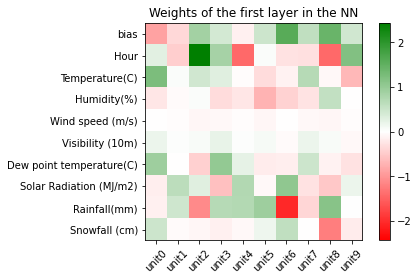

In [31]:
from  matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

columns = ['bias', 'Hour', 'Temperature(C)', 'Humidity(%)',
          'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)',
          'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

W0 = best_model.Ws[0]
n_units = W0.shape[1]

mx = np.max(np.abs(W0))

plt.imshow(W0, vmin=-mx, vmax=mx, cmap=cmap)
xlabels = ['unit{}'.format(y) for y in range(n_units)]
plt.xticks(range(n_units), xlabels, rotation=45)
plt.yticks(range(len(columns)), columns)
plt.title('Weights of the first layer in the NN')
plt.colorbar()

From the `Weights of the first layer in the NN` plot, it is visible that variables `Hour, Temperature(C), Humidity(%), Rainfall(mm), Snowfall(cm)` are some of the most significant positive/negative weights assigned in various hidden layers. Therefore, in this model, these variables can be considered as the most important predictors. 

Both positive and negative weights have been assigned in the abovementioned variables. For example, `Rainfall` has positive weight assigned in unit 8 and negative in unit 6. This may signify opposite correlation to rainfall event and bike hiring. When rainfall is high bike sharing reduces and vice versa. Similar trends can be seen in weights of `Snowfall`. Bike hiring seems to be strongly correlated to `Hour`. Positive weights in `Hour` might indicate peak hours in which bike hiring is high.